In [1]:
import pandas as pd
import numpy as np
import os
import re
import sklearn
from pathlib import Path
from langdetect import detect_langs

import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv("../tos_data/privacy_policy_data.csv", error_bad_lines=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Length    183 non-null    int64 
 1   Link      183 non-null    object
 2   Original  182 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.4+ KB


In [2]:
def remove_multiple_space(sentence):
    clear_sentence = ' '.join(sentence.split())
    #clear_sentence = clear_sentence.lower()
    return clear_sentence

df_raw = df[df['Length'] > 300] # Deleting a HTML's text that was not properly collected.
df_raw['Original'] = df_raw['Original'].astype(str)
df_raw = df_raw.drop_duplicates(['Original'])
df_raw['Original'] = df_raw['Original'].apply(remove_multiple_space)
df_raw.describe(include=object)

<ipython-input-2-1bb8b5900bb7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['Original'] = df_raw['Original'].astype(str)


,Link,Original
count,181,181
unique,181,181
top,https://www.netapp.com/company/legal/privacy-p...,Legal - Privacy Policy - Apple Global Nav Open...
freq,1,1


In [3]:
from spacy.language import Language
import spacy
nlp = spacy.load("en_core_web_sm") # load pre-trained NLP model for sentence segmentation.

df_raw = df_raw.drop(columns=['Length'])

@Language.component("set_custom_boundaries")
def set_custom_boundaries(doc):
    for token in doc[:-1]:
        if token.text == ";":
            doc[token.i + 1].is_sent_start = True
    return doc

def filter_roman_number(s):
    result = []
    for t in s:
        t_result = re.split(r'\(.\) | \(..\) | \(...\) | \(....\)', t)
        result = result + t_result
        
    result = list(filter(None, result))  
    return result

def make_new_row(plist, df_raw_parsed):
    for s in plist:
        new_row = {
            'Link': row['Link'],
            'Original': s,
        }
        df_raw_parsed = df_raw_parsed.append(new_row, ignore_index=True)
    return df_raw_parsed

nlp.add_pipe("set_custom_boundaries", before="parser")
df_raw_parsed = pd.DataFrame(columns=['Link', 'Original'])
for i, row in df_raw.iterrows():
    t_list = [sent.text for sent in nlp(row['Original']).sents]
    f_list = filter_roman_number(t_list)

    if not f_list:
        df_raw_parsed = make_new_row(t_list, df_raw_parsed)
    else:
        df_raw_parsed = make_new_row(f_list, df_raw_parsed)



In [4]:
df_raw_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44051 entries, 0 to 44050
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      44051 non-null  object
 1   Original  44051 non-null  object
dtypes: object(2)
memory usage: 688.4+ KB


In [5]:
df_raw_parsed['Length'] = df_raw_parsed['Original'].apply(lambda x: len(x)) # Create new 'Length' column.
df_raw_parsed = df_raw_parsed[['Length', 'Link', 'Original']]
df_raw_parsed = df_raw_parsed[df_raw_parsed['Length'] > 50]

In [6]:
df_raw_parsed.describe(include=object)

,Link,Original
count,36010,36010
unique,181,31874
top,https://privacy.microsoft.com/en-us/privacysta...,"If you do not allow these cookies, you will ex..."
freq,3021,15


In [7]:
df_raw_parsed['Original'] = df_raw_parsed['Original'].astype(str)
df_raw_parsed = df_raw_parsed.drop_duplicates(['Original']) # Remove duplicate data. Remain unique data in column.
df_raw_parsed.describe(include=object)

,Link,Original
count,31874,31874
unique,181,31874
top,https://privacy.microsoft.com/en-us/privacysta...,Personal Information Sharing We do not sell or...
freq,1520,1


In [8]:
def detect_english_sentence(sentence):
    try:
        res = detect_langs(sentence)
        for item in res:
            if item.lang == "en" and item.prob > 0.99:
                return True
            else:
                return False
    except:
        return False

def make_space(sentence):
    result =[]
    # Insert a space such as "HelloWorld" -> "Hello World"
    result = re.sub(r"([a-z])([A-Z])([a-z])", r"\1 \2\3", sentence)
    return result

for i, row in df_raw_parsed.iterrows():
    if detect_english_sentence(row['Original']) == True:
        result = make_space(row['Original'])
    else:
        result = ""
    df_raw_parsed.loc[i, 'Original'] = result

In [9]:
df_raw_parsed = df_raw_parsed.reset_index(drop=True)
df_raw_parsed = df_raw_parsed[df_raw_parsed['Original'] != '']

In [10]:
# df_raw_parsed.to_csv(Path(os.getcwd() + "/" + "test_pp_data.csv"), index=False) 

In [11]:
# Compare data that calculated length of whole sentence each pandas.
# Through this, you can see how much data is lost after parsing.

# df_raw = df_raw[df_raw['Original'] != '']
# df_raw['Original'] = df_raw['Original'].astype(str)
# df_raw = df_raw.drop_duplicates(['Original'])

# sum_df_raw = 0
# sum_df_raw_parsed = 0

# for i, row in df_raw.iterrows():
#     sum_df_raw = sum_df_raw + len(row['Original'])

# for i, row in df_raw_parsed.iterrows():
#     sum_df_raw_parsed = sum_df_raw_parsed + len(row['Original'])

# print('Before text parsing {0}, After text parsing {1}'.format(sum_df_raw, sum_df_raw_parsed))

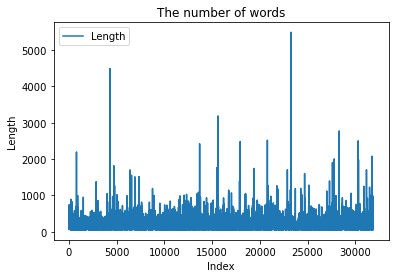

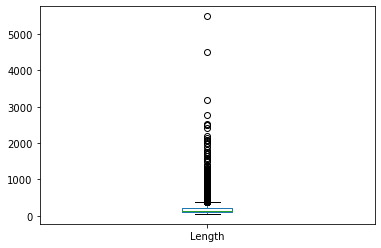

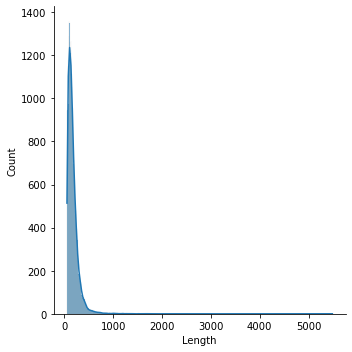

In [12]:
plt.title("The number of words")
plt.xlabel("Index")
plt.ylabel("Length")
plt.plot(df_raw_parsed.index, df_raw_parsed['Length'].values, label='Length')
plt.legend(loc='upper left')
plt.show()
df_raw_parsed.plot(kind='box', figsize=(6,4))
sns.displot(df_raw_parsed['Length'], kde=True)
# Reference: https://datascienceschool.net/01%20python/05.04%20%EC%8B%9C%EB%B3%B8%EC%9D%84%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%ED%8F%AC%20%EC%8B%9C%EA%B0%81%ED%99%94.html

In [13]:
df_raw_parsed.describe(exclude=object)

,Length
count,31213.000000
mean,169.736200
std,127.533175
min,51.000000
25%,98.000000
50%,142.000000
75%,205.000000
max,5487.000000


In [14]:
df_heuristics = pd.read_csv("test_pp_data.csv", error_bad_lines=False)
df_heuristics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31101 entries, 0 to 31100
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Length    31101 non-null  int64 
 1   Link      31101 non-null  object
 2   Original  31101 non-null  object
dtypes: int64(1), object(2)
memory usage: 729.1+ KB


In [15]:
df_heuristics = df_heuristics.sort_values(by='Length') # data sorted by descending order.
df_heuristics = df_heuristics.reset_index(drop=True)
df_heuristics

,Length,Link,Original
0,51,https://www.id.me/privacy,send an email with such a request to privacy@i...
1,51,https://www.aarp.org/about-aarp/privacy-policy/,obtain a copy of such data in an accessible fo...
2,51,https://www.cricketwireless.com/privacy,Requests to delete your CCPA PI are generally ...
3,51,https://www.gartner.com/en/about/policies/privacy,Marketing our conferences through the use of v...
4,51,https://www.cricketwireless.com/privacy,comply with or exercise rights provided by the...
...,...,...,...
31096,2518,https://www.ted.com/about/our-organization/our...,"(To understand the way Google processes, manag..."
31097,2774,https://www.tribpub.com/privacy-policy/,"Other individuals, services, and partners at y..."
31098,3186,https://www.condenast.com/privacy-policy,Payment processors- Database management provid...
31099,4490,https://www.nbcuniversal.com/privacy,Build and manage business-to-business relation...


In [16]:
np.percentile(df_heuristics['Length'], [5, 95], interpolation='nearest') # For readability, extract sentences based on 5%ile, 95%ile.

array([ 62, 356], dtype=int64)

In [17]:
df_heuristics = df_heuristics[(df_heuristics['Length'] >= 62) & (df_heuristics['Length'] <= 356)]
df_heuristics

,Length,Link,Original
1478,62,https://www.ted.com/about/our-organization/our...,Any additional use will be done only with expl...
1479,62,https://www.brightcove.com/en/legal/privacy,We will respond to your request within a reaso...
1480,62,https://www.tribpub.com/privacy-policy/,The Services are not intended for persons unde...
1481,62,https://www.gartner.com/en/about/policies/privacy,It is necessary to comply with applicable laws...
1482,62,https://help.disqus.com/en/articles/1717103-di...,We will use your personal data in the followin...
...,...,...,...
29543,356,https://www.3m.com/3M/en_US/company-us/privacy...,Although we use security measures to help prot...
29544,356,http://www.auburn.edu/privacy,and with external organizations such as the De...
29545,356,https://www.aura.com/legal/privacy-policy,"We implement physical, technical and organizat..."
29546,356,https://www.govexec.com/about/privacy-policy/,"More specifically, we use cookies and other tr..."


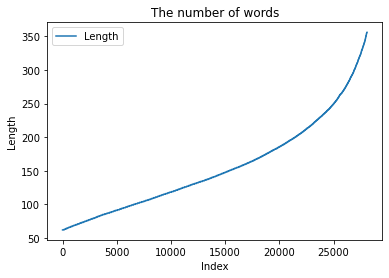

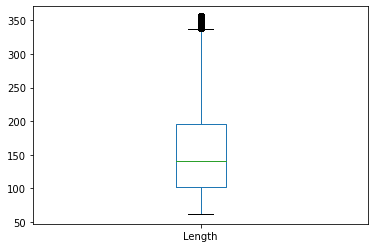

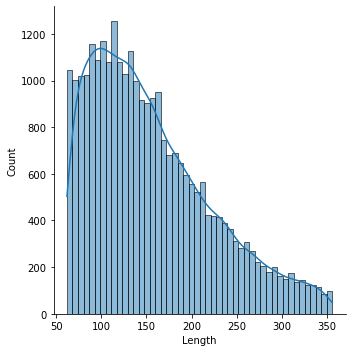

In [18]:
df_heuristics = df_heuristics.reset_index(drop=True)

plt.title("The number of words")
plt.xlabel("Index")
plt.ylabel("Length")
plt.plot(df_heuristics.index, df_heuristics['Length'].values, label='Length')
plt.legend(loc='upper left')
plt.show()
df_heuristics.plot(kind='box', figsize=(6,4))
sns.displot(df_heuristics['Length'], kde=True)

In [19]:
df_mturk = sklearn.utils.shuffle(df_heuristics)
df_mturk = df_mturk.drop(columns=['Length'])

In [20]:
df_mturk_tos = pd.read_csv("mturk_tos_data.csv", error_bad_lines=False)
df_mturk_tos.info() # ToS and T&C data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51144 entries, 0 to 51143
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      51144 non-null  object
 1   Original  51144 non-null  object
dtypes: object(2)
memory usage: 799.2+ KB


In [21]:
df_mturk.info() # privacy policy data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28070 entries, 13843 to 10677
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      28070 non-null  object
 1   Original  28070 non-null  object
dtypes: object(2)
memory usage: 657.9+ KB


In [22]:
df_mturk_concat = pd.concat([df_mturk_tos, df_mturk])
df_mturk_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79214 entries, 0 to 10677
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      79214 non-null  object
 1   Original  79214 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [23]:
df_mturk_final = sklearn.utils.shuffle(df_mturk_concat)

In [24]:
df_failed_mturk = pd.read_csv("../Mturk/mturk_5_data.csv", error_bad_lines=False)
df_failed_mturk = df_failed_mturk[['Input.Original', 'Answer.privacy.label']]
df_failed_mturk

,Input.Original,Answer.privacy.label
0,"The logos, and other trademarks, service marks...",Privacy
1,"The logos, and other trademarks, service marks...",Privacy
2,"The logos, and other trademarks, service marks...",Not privacy
3,"The logos, and other trademarks, service marks...",Privacy
4,"The logos, and other trademarks, service marks...",Privacy
...,...,...
5685,The Services are hosted in the United States a...,Privacy
5686,The Services are hosted in the United States a...,Privacy
5687,The Services are hosted in the United States a...,Privacy
5688,The Services are hosted in the United States a...,Privacy


In [25]:
df_previous500_mturk = pd.read_csv("../Mturk/500_batch_results.csv", error_bad_lines=False)
df_previous500_mturk = df_previous500_mturk[['Input.Original', 'Answer.privacy.label']]
df_previous500_mturk

,Input.Original,Answer.privacy.label
0,"patents, designs, algorithms, utility models, ...",Privacy
1,"patents, designs, algorithms, utility models, ...",Privacy
2,"patents, designs, algorithms, utility models, ...",Privacy
3,"patents, designs, algorithms, utility models, ...",Not privacy
4,"patents, designs, algorithms, utility models, ...",Privacy
...,...,...
2495,"You shall not decompile, disassemble, electron...",Not privacy
2496,"You shall not decompile, disassemble, electron...",Privacy
2497,"You shall not decompile, disassemble, electron...",Not privacy
2498,"You shall not decompile, disassemble, electron...",Not privacy


In [26]:
from collections import Counter
counter = Counter(df_previous500_mturk["Input.Original"])
counter = dict(counter)
duplicate_check_list_500 = list(counter.keys())
len(duplicate_check_list_500)

500

In [27]:
counter = Counter(df_failed_mturk["Input.Original"])
counter = dict(counter)
duplicate_check_list_failed = list(counter.keys())
len(duplicate_check_list_failed)

1138

In [28]:
i = 1
while True:
    df_mturk_final_8468 = df_mturk_final.sample(n=8468, random_state=i)
    if df_mturk_final_8468[df_mturk_final_8468['Original'].isin(duplicate_check_list_failed)].shape[0] == 0 \
        and df_mturk_final_8468[df_mturk_final_8468['Original'].isin(duplicate_check_list_500)].shape[0] == 0:
        break
    i = i + 1
print(i)

22925


In [29]:
df_mturk_final_8468 = df_mturk_final.sample(n=8468, random_state=i) 
df_mturk_final_8468.to_csv(Path(os.getcwd() + "/" + "mturk_tos8468_data.csv"), index=False)

In [30]:
df_mturk_final_8468[df_mturk_final_8468['Original'].isin(duplicate_check_list_500)]

,Link,Original


In [31]:
df_mturk_final_8468[df_mturk_final_8468['Original'].isin(duplicate_check_list_failed)]

,Link,Original
